In [1]:
## results model meixi 
## IMPORT ALLELES FREQ 
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
dict_offset_nooffset_partitions = pd.read_csv('/home/tbellagio/scratch/slim_grenenet/data/dict_offset_nooffset_partitions.csv')

pattern = os.path.join('/home/tbellagio/scratch/slim_grenenet/results', '**', 'lmm_pc_results10env.csv')
 
lmm_pc_results_files = glob.glob(pattern, recursive=True)

In [4]:
results_list = []
for i in lmm_pc_results_files:
    results = pd.read_csv(i)
    results_list.append(len(results))

In [87]:
def add_missing_rows(results_lmm):
    max_value = results_lmm.index.str.split('.').str[1].astype(int).max()
    expected_rows = [f'result.{i}' for i in range(1,max_value + 1)]
    missing_rows = set(expected_rows) - set(results_lmm.index)
    #check 
    #set(results_lmm.index) -  set(expected_rows)

    # Initialize an empty list to store dictionaries
    list_of_dicts = []

    # Create dictionaries for each index value and add them to the list
    for index in missing_rows:
        new_row = {'index': index, 'R2m': np.nan, 'R2c': np.nan, 'beta': np.nan, 'beta_p': np.nan, 'BIC': np.nan}
        list_of_dicts.append(new_row)

    # Create a DataFrame from the list of dictionaries
    missing_rows = pd.DataFrame(list_of_dicts)

    results_lmm = results_lmm.reset_index()
    results_lmm = pd.concat([results_lmm,missing_rows])
    results_lmm['index'] = results_lmm['index'].str.split('.').str[1].astype(int)

    results_lmm = results_lmm.sort_values(by = 'index')

    results_lmm = results_lmm.reset_index(drop=True).drop('index',axis=1)
    #len(results_lmm)

    return results_lmm

In [ ]:
def metrics_wtreshold(name, results_lmm, th, min_pvalue):

    results_lmm['sig'] = results_lmm['p_value_env']<= th

    true_positives = len(results_lmm[(results_lmm['is_within_range'] ==True) & (results_lmm['sig'] ==True)])

    true_negatives = len(results_lmm[(results_lmm['is_within_range'] ==False) & (results_lmm['sig'] ==False)])

    false_negatives = len(results_lmm[(results_lmm['is_within_range'] ==True) & (results_lmm['sig'] ==False)])

    false_positives = len(results_lmm[(results_lmm['is_within_range'] ==False) & (results_lmm['sig'] ==True)])

    if false_positives + true_positives == 0:
        fdr = np.nan  # Set FDR to 0 if the denominator is zero
    else:
        fdr = false_positives / (false_positives + true_positives)

    new_row = {'name': name,
               'true_positives': true_positives,
               'true_negatives': true_negatives,
               'false_negatives': false_negatives,
               'false_positives': false_positives,
               'fdr': fdr,
               'min_p_value': min_pvalue, 
               'th': str(th)}

    return new_row

In [ ]:
result_metrics = pd.DataFrame(columns=['name', 'true_positives', 'true_negatives', 'false_negatives', 'false_positives', 'fdr', 'min_p_value', 'th'])

for result in lmm_pc_results_files: 

    name = result.split('/')[-3] + '_' + result.split('/')[-4] + '_' + result.split('/')[-5]

    allele_freq_norm_file = result.replace('/lmm/lmm_pc_results10env.csv','/allele_freq_norm10env.csv')
    causal_loci_file = result.split('arq')[0] + 'arq' + result.split('arq')[1].split('/')[0] + '/loci_effectsize.csv'

    results_lmm = pd.read_csv(result,index_col=[0])

    bc = 0.05 / len(results_lmm)

    ## first i need to check that all results are there 
    results_lmm = add_missing_rows(results_lmm)

    ## read allele freq norm to get chrom pos 
    allele_freq_norm = pd.read_csv(allele_freq_norm_file)
    results_lmm = pd.concat([allele_freq_norm['chrom_pos'], results_lmm],axis=1)

    #get the causal loci 
    causal_loci = pd.read_csv(causal_loci_file)
    causal_loci = causal_loci.merge(dict_offset_nooffset_partitions, left_on = 'pos', right_on = 'offset')
    results_lmm = results_lmm.merge(dict_offset_nooffset_partitions[['offset', 'partition']], left_on = 'chrom_pos', right_on = 'offset')
    results_lmm.loc[:, 'is_within_range'] = results_lmm['partition'].isin(causal_loci['partition'])


    ## get the min p value for teh records 
    min_pvalue = results_lmm['p_value_env'].min()


    for i in [0.05, 0.0005, 0.000005, 0.00000005, bc]:
        new_row = metrics_wtreshold(name, results_lmm, i, min_pvalue)
        result_metrics.loc[len(result_metrics)] = new_row
result_metrics.to_csv('results_lmm_pc_10env.csv')

In [131]:
df = pd.read_csv('results_lmm_pc_10env.csv').drop('Unnamed: 0',axis=1)

df.columns

Index(['name', 'true_positives', 'true_negatives', 'false_negatives',
       'false_positives', 'fdr', 'min_p_value', 'th'],
      dtype='object')

In [132]:
# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
df['tpr'] = df['true_positives'] / (df['true_positives'] + df['false_negatives'])
df['fpr'] = df['false_positives'] / (df['false_positives'] + df['true_negatives'])

,name,true_positives,true_negatives,false_negatives,false_positives,fdr,min_p_value,th,tpr,fpr
694,strongsel_mediumh_arq_lowfreq_monogen_3,6,3235144,330,0,0.0,1.556559e-12,1.545366e-08,0.017857,0.0
693,strongsel_mediumh_arq_lowfreq_monogen_3,6,3235144,330,0,0.0,1.556559e-12,5.000000e-08,0.017857,0.0
692,strongsel_mediumh_arq_lowfreq_monogen_3,6,3235144,330,0,0.0,1.556559e-12,5.000000e-06,0.017857,0.0
341,strongsel_highh_arq_mediumfreq_monogen_1,1,3228361,7118,0,0.0,3.154212e-05,5.000000e-04,0.000140,0.0
340,strongsel_highh_arq_mediumfreq_monogen_1,1,3228361,7118,0,0.0,3.154212e-05,5.000000e-02,0.000140,0.0
...,...,...,...,...,...,...,...,...,...,...
895,strongsel_highh_arq_lowfreq_monogen_4,0,3232152,3293,0,NaN,6.681358e-01,5.000000e-02,0.000000,0.0
896,strongsel_highh_arq_lowfreq_monogen_4,0,3232152,3293,0,NaN,6.681358e-01,5.000000e-04,0.000000,0.0
897,strongsel_highh_arq_lowfreq_monogen_4,0,3232152,3293,0,NaN,6.681358e-01,5.000000e-06,0.000000,0.0
898,strongsel_highh_arq_lowfreq_monogen_4,0,3232152,3293,0,NaN,6.681358e-01,5.000000e-08,0.000000,0.0


In [134]:
df.sort_values('fdr').head(30)

,name,true_positives,true_negatives,false_negatives,false_positives,fdr,min_p_value,th,tpr,fpr
694,strongsel_mediumh_arq_lowfreq_monogen_3,6,3235144,330,0,0.000000,1.556559e-12,1.545366e-08,0.017857,0.000000e+00
693,strongsel_mediumh_arq_lowfreq_monogen_3,6,3235144,330,0,0.000000,1.556559e-12,5.000000e-08,0.017857,0.000000e+00
692,strongsel_mediumh_arq_lowfreq_monogen_3,6,3235144,330,0,0.000000,1.556559e-12,5.000000e-06,0.017857,0.000000e+00
341,strongsel_highh_arq_mediumfreq_monogen_1,1,3228361,7118,0,0.000000,3.154212e-05,5.000000e-04,0.000140,0.000000e+00
340,strongsel_highh_arq_mediumfreq_monogen_1,1,3228361,7118,0,0.000000,3.154212e-05,5.000000e-02,0.000140,0.000000e+00
181,strongsel_highh_arq_lowfreq_monogen_1,1,3235339,139,1,0.500000,8.603122e-05,5.000000e-04,0.007143,3.090865e-07
180,strongsel_highh_arq_lowfreq_monogen_1,1,3235339,139,1,0.500000,8.603122e-05,5.000000e-02,0.007143,3.090865e-07
485,strongsel_highh_arq_lowfreq_onehpoly_2,9064,2836399,319660,70357,0.885874,6.325545e-03,5.000000e-02,0.027573,2.420465e-02
750,strongsel_highh_arq_lowfreq_onehpoly_1,6978,2822954,345653,59895,0.895653,4.000807e-03,5.000000e-02,0.019788,2.077632e-02
15,strongsel_highh_arq_lowfreq_onehpoly_4,5252,2849234,334053,46941,0.899373,1.883170e-02,5.000000e-02,0.015479,1.620793e-02


In [49]:
data = [
    {'name': 'Trace 1', 'x': [1, 2, 3, 4, 5], 'y': [10, 14, 18, 24, 30]},
    {'name': 'Trace 2', 'x': [1, 2, 3, 4, 5], 'y': [5, 8, 12, 17, 22]},
    {'name': 'Trace 3', 'x': [1, 2, 3, 4, 5], 'y': [2, 4, 7, 11, 16]}
]

In [50]:
data

[{'name': 'Trace 1', 'x': [1, 2, 3, 4, 5], 'y': [10, 14, 18, 24, 30]},
 {'name': 'Trace 2', 'x': [1, 2, 3, 4, 5], 'y': [5, 8, 12, 17, 22]},
 {'name': 'Trace 3', 'x': [1, 2, 3, 4, 5], 'y': [2, 4, 7, 11, 16]}]

In [63]:
(tpr + fpr).sum()

0.0

In [71]:
plot_auc = []
auc_list = []
for i in df['name'].unique():
    df1 = df[df['name'] == i]
    df1 = df1.sort_values(by='th', ascending=True)
    tpr = df1['tpr'].values
    fpr = df1['fpr'].values
    auc = metrics.auc(fpr, tpr)
    auc_list.append(auc)
    if (tpr + fpr).sum() != 0:
        data1 = {'name': i, 'fpr': fpr, 'tpr': tpr}
        plot_auc.append(data1)

In [77]:
auc = pd.DataFrame({'name': df['name'].unique(), 'auc': auc_list})

In [78]:
auc.sort_values('auc')

,name,auc
0,strongsel_mediumh_arq_highfreq_onehpoly_4,0.000000
109,strongsel_mediumh_arq_mediumfreq_fivepoly_1,0.000000
110,strongsel_lowh_arq_mediumfreq_fivepoly_1,0.000000
111,strongsel_highh_arq_mediumfreq_monogen_4,0.000000
112,strongsel_lowh_arq_mediumfreq_monogen_4,0.000000
...,...,...
138,strongsel_mediumh_arq_lowfreq_monogen_3,0.014812
70,strongsel_mediumh_arq_lowfreq_fivepoly_1,0.017666
38,strongsel_mediumh_arq_lowfreq_monogen_1,0.021974
21,strongsel_mediumh_arq_lowfreq_fivepoly_5,0.027874


In [32]:
df = df.sort_values(by='th', ascending=True)

In [36]:
df['tpr'].values

array([0.01785714, 0.01785714, 0.01785714, 0.01785714, 0.14583333])

In [37]:
df['fpr'].values

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.75854181e-05,
       1.81041400e-01])

In [28]:
import numpy as np
from sklearn import metrics
y = np.array([1, 1, 2, 2])
pred = np.array([0.1, 0.4, 0.35, 0.8])
fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=2)
metrics.auc(fpr, tpr)

0.75

In [41]:
auc =  metrics.auc(df['fpr'].values, df['tpr'].values)

In [31]:
thresholds

array([1.8 , 0.8 , 0.4 , 0.35, 0.1 ])

In [29]:
fpr

array([0. , 0. , 0.5, 0.5, 1. ])

In [30]:
tpr

array([0. , 0.5, 0.5, 1. , 1. ])

In [24]:

# Sort the DataFrame by 'significance_level'


# Calculate AUC (Area Under the Curve)
auc = sum(df['tpr'].diff() * (df['fpr'].shift(-1) + df['fpr']) / 2)

In [ ]:
>>> from sklearn import metrics


In [25]:
sum(df['tpr'].diff() * (df['fpr'].shift(-1) + df['fpr']) / 2)

nan

In [65]:
plot_auc

[{'name': 'strongsel_highh_arq_lowfreq_onehpoly_4',
  'x': array([0.        , 0.        , 0.        , 0.        , 0.01620793]),
  'y': array([0.       , 0.       , 0.       , 0.       , 0.0154787])},
 {'name': 'strongsel_mediumh_arq_lowfreq_twentypoly_4',
  'x': array([0.        , 0.        , 0.        , 0.        , 0.01371701]),
  'y': array([0.       , 0.       , 0.       , 0.       , 0.0131554])},
 {'name': 'strongsel_highh_arq_lowfreq_twentypoly_4',
  'x': array([1.30982046e-05, 1.62928886e-05, 1.29704172e-04, 1.80435755e-03,
         5.19944412e-02]),
  'y': array([0.00000000e+00, 9.49848024e-06, 4.74924012e-05, 1.03533435e-03,
         4.57066869e-02])},
 {'name': 'strongsel_mediumh_arq_lowfreq_fivepoly_5',
  'x': array([0.00140312, 0.00191519, 0.00758861, 0.04094114, 0.23966841]),
  'y': array([1.04810816e-04, 1.57216225e-04, 2.09621633e-03, 3.24913531e-02,
         2.42165391e-01])},
 {'name': 'strongsel_highh_arq_lowfreq_fivepoly_5',
  'x': array([0.00000000e+00, 0.00000000e+0

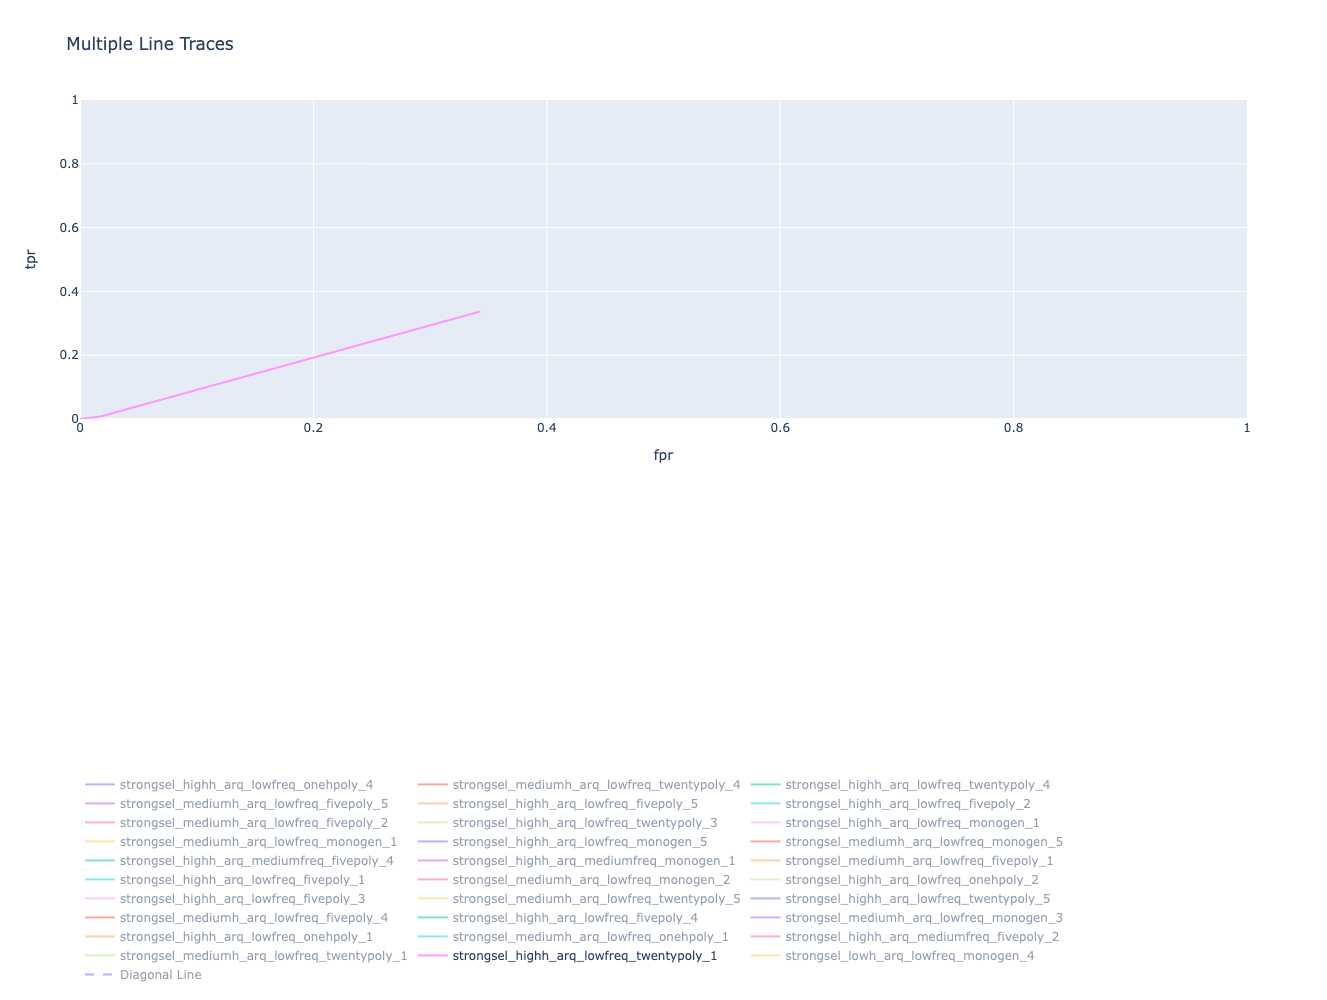

In [70]:
import plotly.graph_objs as go


# Create line traces using a loop
traces = []
for trace_data in plot_auc:
    trace = go.Scatter(x=trace_data['fpr'], y=trace_data['tpr'], mode='lines', name=trace_data['name'])
    traces.append(trace)

# Create a diagonal line trace
diagonal_line = go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Diagonal Line', line=dict(dash='dash'))

# Create a layout
layout = go.Layout(
    title='Multiple Line Traces',
    xaxis=dict(title='fpr', range=[0, 1]),
    yaxis=dict(title='tpr', range=[0, 1]),
    legend=dict(orientation='h', y=-1.1),
    width=800,  # Set the width of the plot
    height=1000,  # Set the height of the plot
)

# Create a figure
fig = go.Figure(data=traces + [diagonal_line], layout=layout)

# Show the plot
fig.show()
# strongsel_highh_arq_lowfreq_twentypoly_1

In [26]:
df['tpr'].diff()

690         NaN
691   -0.127976
692    0.000000
693    0.000000
694    0.000000
Name: tpr, dtype: float64

In [27]:
df['fpr'].shift(-1) + df['fpr']

690    0.181119
691    0.000078
692    0.000000
693    0.000000
694         NaN
Name: fpr, dtype: float64

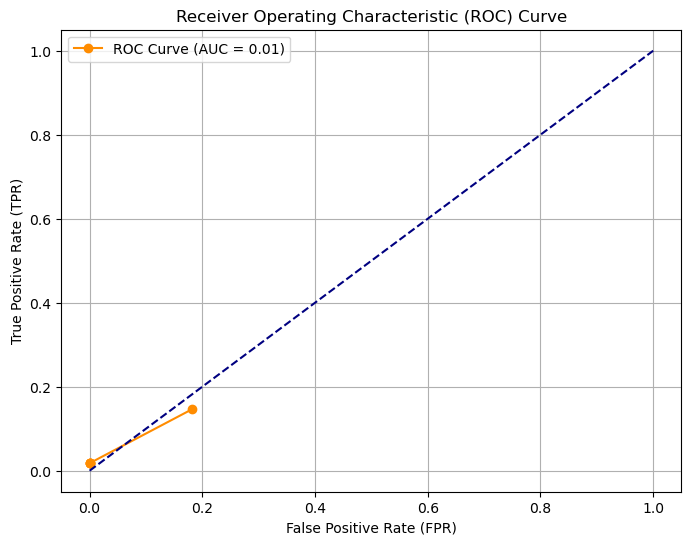

AUC: 0.01


In [42]:
# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(df['fpr'], df['tpr'], marker='o', linestyle='-', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(['ROC Curve (AUC = {:.2f})'.format(auc)])
plt.grid(True)
plt.show()

print(f'AUC: {auc:.2f}')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data (replace with your list of DataFrames)
data = [
    {
        'true_positives': [30, 40, 50, 60, 70],
        'true_negatives': [70, 60, 50, 40, 30],
        'false_negatives': [10, 20, 30, 40, 50],
        'false_positives': [30, 20, 10, 0, 0],
        'fdr': [0.5, 0.333, 0.2, 0.0, 0.0],
        'significance_level': [0.1, 0.2, 0.3, 0.4, 0.5],
        'model_name': 'Model 1'
    },
    {
        'true_positives': [25, 35, 45, 55, 65],
        'true_negatives': [75, 65, 55, 45, 35],
        'false_negatives': [15, 25, 35, 45, 55],
        'false_positives': [25, 15, 5, 0, 0],
        'fdr': [0.5, 0.3, 0.1, 0.0, 0.0],
        'significance_level': [0.1, 0.2, 0.3, 0.4, 0.5],
        'model_name': 'Model 2'
    }
]

# Create a figure and axis for plotting
plt.figure(figsize=(8, 6))

# Loop through the list of models
for model_data in data:
    df = pd.DataFrame(model_data)
    
    # Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
    df['tpr'] = df['true_positives'] / (df['true_positives'] + df['false_negatives'])
    df['fpr'] = df['false_positives'] / (df['false_positives'] + df['true_negatives'])
    
    # Sort the DataFrame by 'significance_level'
    df = df.sort_values(by='significance_level', ascending=False)
    
    # Plot ROC Curve for the model
    plt.plot(df['fpr'], df['tpr'], marker='o', linestyle='-', label=model_data['model_name'])

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Add labels and legend
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')

# Show the plot
plt.grid(True)
plt.show()


In [ ]:
results_lmm[(results_lmm['is_within_range'] ==False) & (results_lmm['sig'] ==False)]

In [238]:
confusion = confusion_matrix(results_lmm['sig'], results_lmm['is_within_range'])

print("Confusion Matrix:")
print(confusion)

Confusion Matrix:
[[1332253    1776]
 [ 309479     364]]


<Axes: >

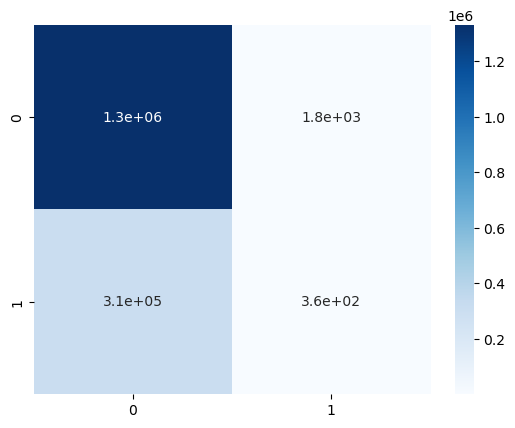

In [239]:
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion, annot=True, cmap='Blues')

In [80]:
lmm_pc_results_files

['/home/tbellagio/scratch/slim_grenenet/results/arq_highfreq_onehpoly_4/mediumh/strongsel/lmm/lmm_pc_results10env.csv',
 '/home/tbellagio/scratch/slim_grenenet/results/arq_highfreq_onehpoly_4/lowh/strongsel/lmm/lmm_pc_results10env.csv',
 '/home/tbellagio/scratch/slim_grenenet/results/arq_highfreq_onehpoly_4/highh/strongsel/lmm/lmm_pc_results10env.csv',
 '/home/tbellagio/scratch/slim_grenenet/results/arq_lowfreq_onehpoly_4/highh/strongsel/lmm/lmm_pc_results10env.csv',
 '/home/tbellagio/scratch/slim_grenenet/results/arq_lowfreq_onehpoly_4/mediumh/strongsel/lmm/lmm_pc_results10env.csv',
 '/home/tbellagio/scratch/slim_grenenet/results/arq_lowfreq_onehpoly_4/lowh/strongsel/lmm/lmm_pc_results10env.csv',
 '/home/tbellagio/scratch/slim_grenenet/results/arq_highfreq_twentypoly_4/highh/strongsel/lmm/lmm_pc_results10env.csv',
 '/home/tbellagio/scratch/slim_grenenet/results/arq_highfreq_twentypoly_4/lowh/strongsel/lmm/lmm_pc_results10env.csv',
 '/home/tbellagio/scratch/slim_grenenet/results/arq_hi

In [ ]:
strongsel_mediumh_arq_lowfreq_monogen_3

In [137]:
result =  '/home/tbellagio/scratch/slim_grenenet/results/arq_mediumfreq_twentypoly_4/mediumh/strongsel/lmm/lmm_pc_results10env.csv'

In [138]:
allele_freq_norm_file = result.replace('/lmm/lmm_pc_results10env.csv','/allele_freq_norm10env.csv')
causal_loci_file = result.split('arq')[0] + 'arq' + result.split('arq')[1].split('/')[0] + '/loci_effectsize.csv'

results_lmm = pd.read_csv(result,index_col=[0])

bc = 0.05 / len(results_lmm)

## first i need to check that all results are there 
results_lmm = add_missing_rows(results_lmm)

In [139]:
## read allele freq norm to get chrom pos 
allele_freq_norm = pd.read_csv(allele_freq_norm_file)
results_lmm = pd.concat([allele_freq_norm['chrom_pos'], results_lmm],axis=1)

#get the causal loci 
causal_loci = pd.read_csv(causal_loci_file)
causal_loci = causal_loci.merge(dict_offset_nooffset_partitions, left_on = 'pos', right_on = 'offset')
results_lmm = results_lmm.merge(dict_offset_nooffset_partitions[['offset', 'partition']], left_on = 'chrom_pos', right_on = 'offset')
results_lmm.loc[:, 'is_within_range'] = results_lmm['partition'].isin(causal_loci['partition'])

In [140]:
## get chromosome for plot
dict_offset_nooffset_partitions['chr'] = dict_offset_nooffset_partitions['nooffset'].str.split('_').str[0]
results_lmm = results_lmm.merge(dict_offset_nooffset_partitions[['offset','chr']], left_on = 'chrom_pos' , right_on = 'offset' )

In [141]:
#colors
custom_categories = results_lmm['chr'].unique()
custom_colors = sns.color_palette("Greens", n_colors=len(custom_categories))

# Create a custom color dictionary
custom_color_dict = dict(zip(custom_categories, custom_colors))

In [142]:
results_lmm['log_pvalue'] = -np.log10(results_lmm['p_value_env'])

In [143]:
df = results_lmm.copy()

In [144]:
df[df['is_within_range']]

,chrom_pos,env_value,env_eror,p_value_env,intercept_value,intercept_eror,bic,lrt,offset_x,partition,is_within_range,offset_y,chr,log_pvalue
62532,3133243,-0.001154,0.120356,0.992519,-1.286480,0.380257,116.597551,0.992519,3133243,248,True,3133243,1,0.003261
62533,3133256,-0.019526,0.068304,0.780210,-0.730412,0.215721,72.785490,0.780210,3133256,248,True,3133256,1,0.107789
62534,3133257,-0.019526,0.068304,0.780210,-0.730412,0.215721,72.785490,0.780210,3133257,248,True,3133257,1,0.107789
62535,3133274,0.297390,0.216497,0.202907,0.261790,0.682925,251.447507,0.202907,3133274,248,True,3133274,1,0.692704
62536,3133296,-0.109927,0.081430,0.205148,-0.540064,0.257104,104.237606,0.205148,3133296,248,True,3133296,1,0.687933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2891990,107219231,0.002738,0.044397,0.951919,-0.744298,0.140188,34.892899,0.951919,107219231,10419,True,107219231,5,0.021400
2891991,107219232,-0.052034,0.060247,0.406352,-0.761139,0.190378,29.672751,0.406352,107219232,10419,True,107219232,5,0.391097
2891992,107219233,-0.025593,0.050653,0.625647,-0.632328,0.159840,122.301848,0.625647,107219233,10419,True,107219233,5,0.203671
2891993,107219235,0.473986,0.325248,0.173683,0.910279,1.027976,200.135125,0.173683,107219235,10419,True,107219235,5,0.760242


In [146]:
5.000000e-02

0.05

/home/tbellagio/mambaforge/envs/pipeline_snakemake/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



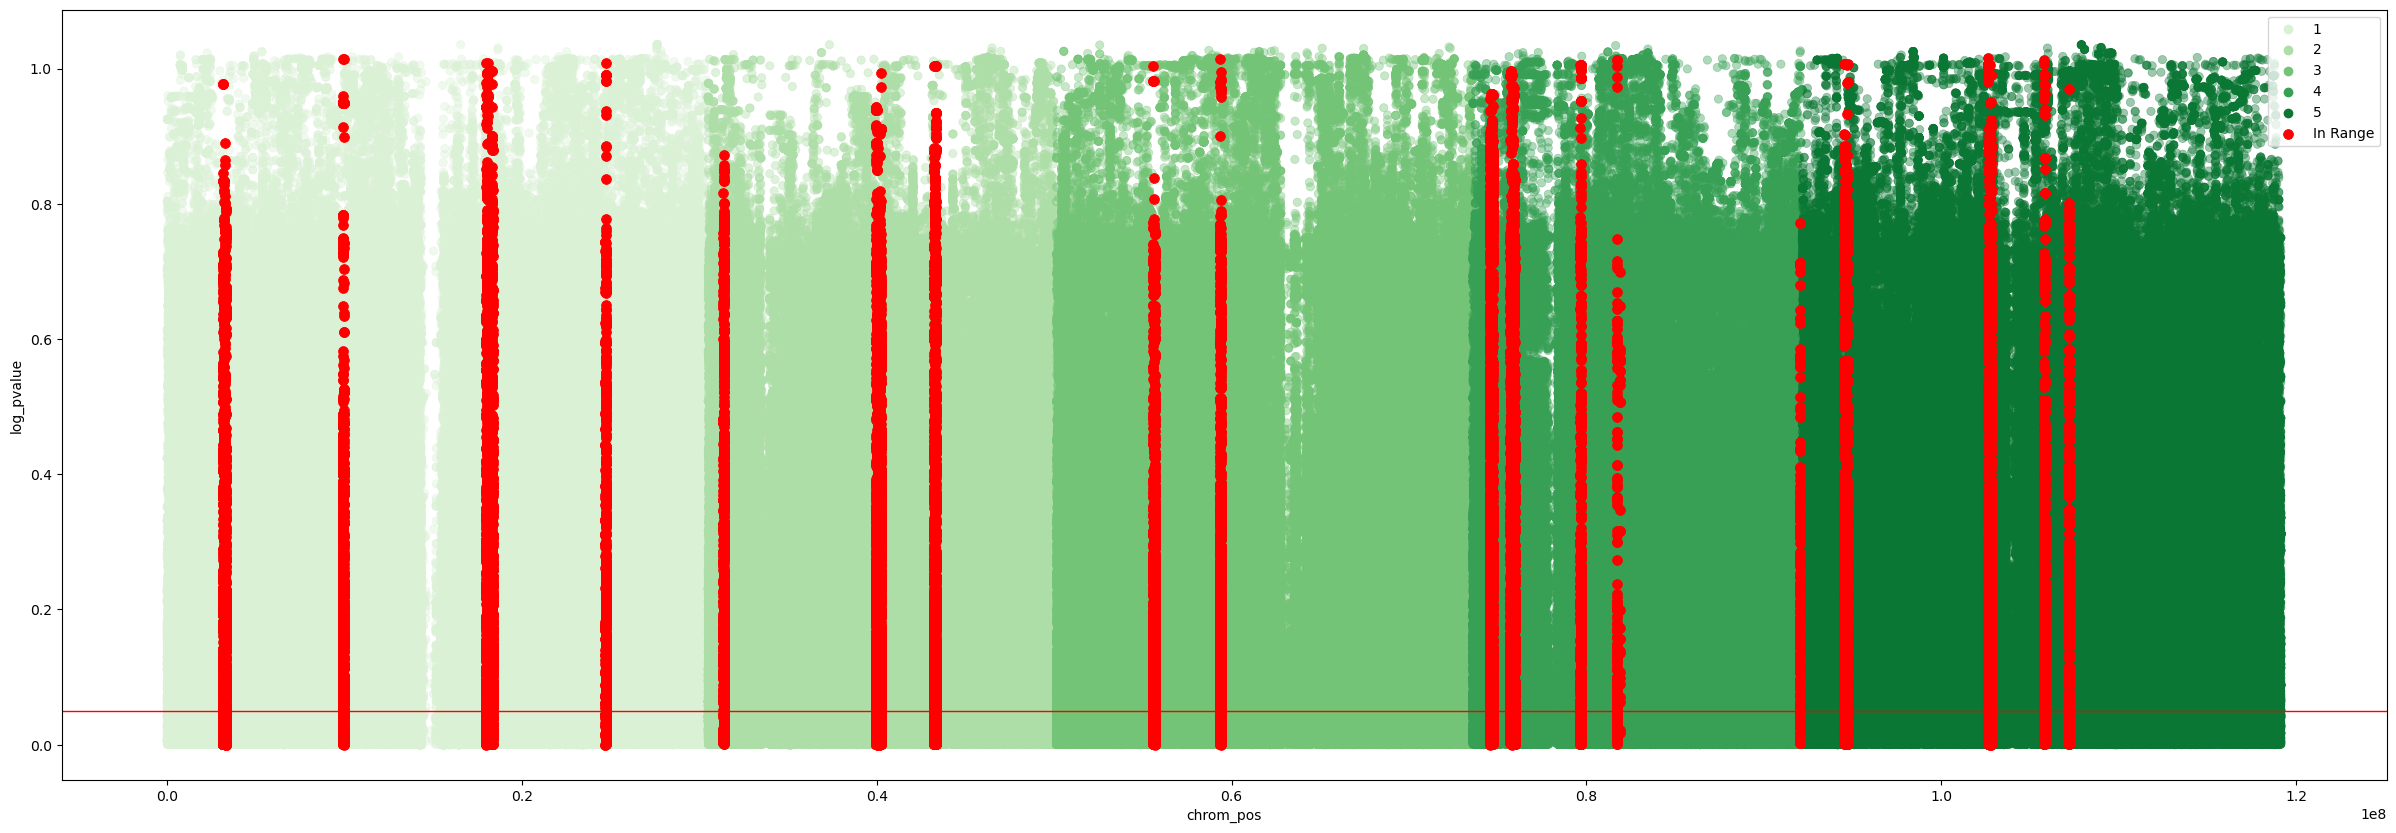

In [147]:
significance_threshold = -np.log10(0.05/ (len(df)))
significance_threshold = 5.000000e-02
# Your GWAS scatterplot code with custom colors, alpha, vertical lines, and annotations
plt.figure(figsize=(30, 10))
sns.scatterplot(data=df, x='chrom_pos', y='log_pvalue', hue='chr', alpha=0.4, palette=custom_color_dict, edgecolor=None)

# Add vertical lines and annotations for each position in the list
#for sc, pos in zip(causal_loci['sc'], causal_loci['pos']):
#    plt.axvline(x=pos, color='grey', linestyle='--', linewidth=1)
#    plt.text(pos, plt.ylim()[1], round(sc, 2), ha='center', va='bottom', color='grey', fontsize=12)

# Add a horizontal line for significance threshold
sns.scatterplot(data=df[df['is_within_range']], x='chrom_pos', y='log_pvalue', color='red', s=50, label='In Range', edgecolor=None)

plt.axhline(y=significance_threshold, color='red', linestyle='-', linewidth=1)

# Show the plot
plt.show()

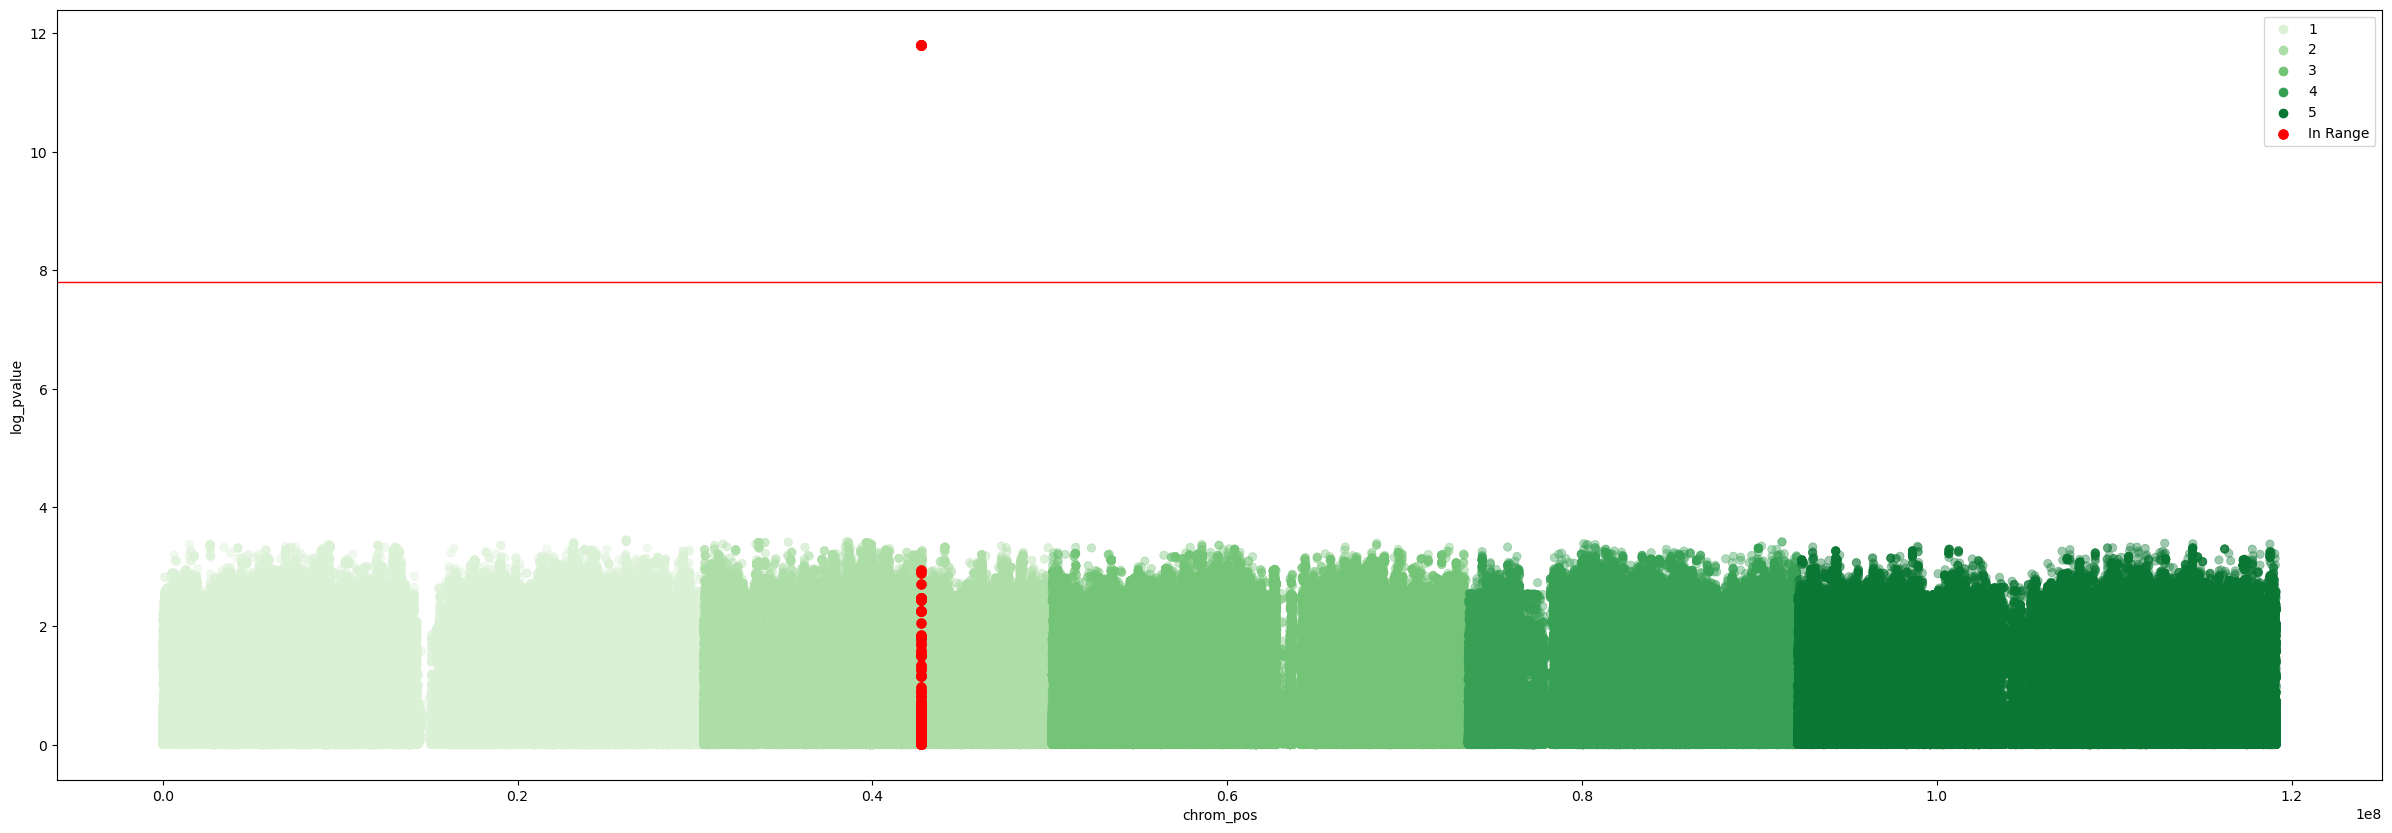

In [130]:
significance_threshold = -np.log10(0.05/ (len(df)))

# Your GWAS scatterplot code with custom colors, alpha, vertical lines, and annotations
plt.figure(figsize=(30, 10))
sns.scatterplot(data=df, x='chrom_pos', y='log_pvalue', hue='chr', alpha=0.4, palette=custom_color_dict, edgecolor=None)

# Add vertical lines and annotations for each position in the list
#for sc, pos in zip(causal_loci['sc'], causal_loci['pos']):
#    plt.axvline(x=pos, color='grey', linestyle='--', linewidth=1)
#    plt.text(pos, plt.ylim()[1], round(sc, 2), ha='center', va='bottom', color='grey', fontsize=12)

# Add a horizontal line for significance threshold
sns.scatterplot(data=df[df['is_within_range']], x='chrom_pos', y='log_pvalue', color='red', s=50, label='In Range', edgecolor=None)

plt.axhline(y=significance_threshold, color='red', linestyle='-', linewidth=1)

# Show the plot
plt.show()

In [ ]:
sns.scatterplot(data=df[df['in_range']], x='offset', y='logpvalue', color='red', s=100, label='In Range', edgecolor=None)


In [ ]:
significance_threshold = -np.log10(0.05/ (len(df)))

# Your GWAS scatterplot code with custom colors, alpha, vertical lines, and annotations
plt.figure(figsize=(30, 10))
sns.scatterplot(data=df, x='offset', y='logpvalue', hue='chr', alpha=0.8, palette=custom_color_dict, edgecolor=None)

plt.axhline(y=significance_threshold, color='red', linestyle='-', linewidth=1)

# Show the plot
plt.show()